# **Carlini and Wagner** Attack and Binary Input Detector Using CIFAR10

This notebook shows the Carlini and Wagner attack implmentation using the ART library against deep learning models trained on CIFAR-10 dataset. The notebook covers the following:

* Load the required libariries
* Load the dataset and inspect the data
* Create a deep learning model
* Train and evaluate the deep learning model on the test
* Implement C&W attack using ART
* Create adversarial samples using the C&W attack
* Evaluate the deep leaarning model against the adversaarial samples
* Create a detector model to detect adversarial samples
* Train and evaluate the detector model




### **Carlini and Wagner (C&W) Attack - Overview**

The **Carlini and Wagner (C&W)** attack, introduced by **Nicholas Carlini** and **David Wagner** in 2017, is one of the most powerful and effective methods for generating adversarial examples. It is designed to be more effective and difficult to defend against compared to other adversarial attacks like **FGSM** and **PGD**.

The C&W attack specifically addresses some of the limitations of earlier methods by framing the generation of adversarial examples as an **optimization problem**. The attack minimizes a combination of the perturbation's magnitude and the model's loss (misclassification), while also introducing a regularization term to control the perceptibility of the adversarial perturbation.

#### **Key Concepts:**

**1. Adversarial Example:** A slightly modified version of the input that is intentionally crafted to cause a model to misclassify it.

**2. Optimization Problem:** The C&W attack formulates the creation of an adversarial example as an optimization problem, where the goal is to minimize a loss function that balances:
* The difference between the original and adversarial inputs (i.e., the perturbation magnitude).
* The model's confidence in the adversarial class (i.e., the model's misclassification).

**3. Regularization:** C&W uses regularization to ensure that the perturbation is not too large, which keeps the adversarial example visually similar to the original input.

#### **How the Carlini and Wagner Attack Works**

The C&W attack minimizes a loss function that includes three key components:

**1. The Loss for Misclassification:** Ensuring that the adversarial example is classified as the wrong class.

**2. The Perturbation Size:** Keeping the perturbation (i.e., the difference between the original and adversarial input) small.

**3. Regularization:** A term that controls the magnitude of the perturbation to ensure the adversarial example is visually similar to the original.

#### **Objective Function**

The C&W attack solves an optimization problem that minimizes the following objective function:
$$L(x_{adv},x,y)=max(0,f(x_{adv})_{y_{target}}−f(x_{adv})y+δ)+λ∥x_{adv}−x∥_{p}$$

Where:

* $x_{adv}$​ is the adversarial example.
* $x$ is the original input.
* $y$ is the true label of the input $x$.
* $y_{target}$​ is the target class that we want the adversarial example to be classified as. If we're performing a targeted attack, we set ytargetytarget​ to be a specific class (different from the original class), otherwise, it will simply aim to misclassify the input.
* $f(x_{adv})_{y}$​ and $f(x_{adv})_{y_{target}}$​​ represent the logits (raw output scores) of the model for the true label $y$ and the target label $y_{target}$​, respectively.
* $δ$ is a small constant that makes sure that the misclassification loss doesn't vanish.
* $λ$ is a regularization hyperparameter that controls the tradeoff between the loss for misclassification and the perturbation size.
* $∥x_{adv}−x∥_{p}$​ is the pp-norm distance (usually $p=2$, i.e., the Euclidean norm), which measures the magnitude of the perturbation between the adversarial example and the original input.

#### **Detailed Breakdown of the Objective Function**

**1. Misclassification Term:**
* The term $max(0,f(x_{adv})_{y_{target}}−f(x_{adv})_{y}+δ)$ ensures that the adversarial example is classified as the target class ytargetytarget​ (for a targeted attack) or misclassified (for an untargeted attack). This is known as a margin loss.
* This term ensures that the logits for the target class are larger than the logits for the original class by at least $δ$. The value of $δ$ is small, but ensures a sufficient gap between the logits of the target class and the original class to successfully fool the model.

**2. Regularization Term:**
* The term $λ∥x_{adv}−x∥_{p}$​ controls the perturbation size. The pp-norm $∥x_{adv}−x∥_{p}$​ measures the difference between the adversarial example and the original input.
* The parameter $λ$ allows us to adjust the tradeoff between making the perturbation smaller (thus keeping the adversarial example visually similar to the original) and fooling the model.

**3. Optimization:**
* The goal is to minimize this objective function. The optimization process is performed using gradient-based methods (such as L-BFGS or Adam), iteratively adjusting $x_{adv}$​ until the model classifies the adversarial example as the target class (or misclassifies it, in the case of an untargeted attack) and the perturbation remains within the desired size.

#### **Targeted vs. Untargeted Attacks**

* **Targeted Attack**: The goal is to make the model classify the adversarial example as a specific class $ytarget$​ that is different from the true class yy. The objective function is minimized such that $f(x_{adv})_{y_{target}}$​ is greater than $f(x_{adv})y$​ by at least $δ$.

* **Untargeted Attack**: The goal is simply to cause the model to misclassify the adversarial example, regardless of which incorrect class it is classified as. In this case, the objective function is adjusted so that the adversarial example's logits for the correct class are smaller than those for any incorrect class.

#### **Steps in the Carlini and Wagner Attack**

**1. Initialize the adversarial example** $x_{adv}​$. This is usually initialized as a slightly perturbed version of the original input $x$.

**2. Iterate the optimization process:**
* Compute the gradient of the objective function with respect to $x_{adv}$​.
* Update $x_{adv}$​ to minimize the objective function, using gradient-based optimization (e.g., L-BFGS).

**3. Termination:** The optimization stops when the adversarial example satisfies the condition for misclassification (or targeted classification) and the perturbation is within the acceptable magnitude range.

#### **Strengths of C&W Attack**

* **High Success Rate:** The C&W attack is known to be very effective against a wide range of defense mechanisms, including adversarial training and defensive distillation.
* **Controllable Perturbation:** By adjusting the regularization term $λ$, C&W allows for fine-grained control over the magnitude of the perturbation. This makes it possible to generate adversarial examples that are visually indistinguishable from the original inputs.
* **Targeted and Untargeted Options:** The attack is flexible, supporting both targeted and untargeted attacks.

#### **Weaknesses of C&W Attack**

* **Computationally Expensive:** The optimization process is more computationally expensive compared to methods like FGSM and PGD, as it involves iterative optimization and requires significant computational resources, especially for large models or high-dimensional inputs (such as images).
* **Optimization Sensitivity:** The success of the attack depends on the choice of hyperparameters, particularly $λ$, $δ$, and the optimization method. Improper tuning can lead to suboptimal results.

### Install and import required Libraries

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import CarliniLInfMethod, CarliniL0Method, CarliniL2Method
from art.defences.detector.evasion import BinaryActivationDetector

2025-01-16 11:14:09.756904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 11:14:09.856763: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[2], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

3 Physical GPUs, 1 Logical GPU


2025-01-16 11:14:41.513491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 11:14:41.907373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32548 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5


### Load MNIST dataset

In [6]:
# (x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# Load the dataset from the local drive
data = np.load('./../Datasets/cifar10_dataset.npz')
x_train, y_train, x_test, y_test= data['X_train'], data['y_train'], data['X_test'], data['y_test']

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

min = x_train.min()
max = x_train.max()

x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10), 0.0, 1.0)

### Inspect the Data

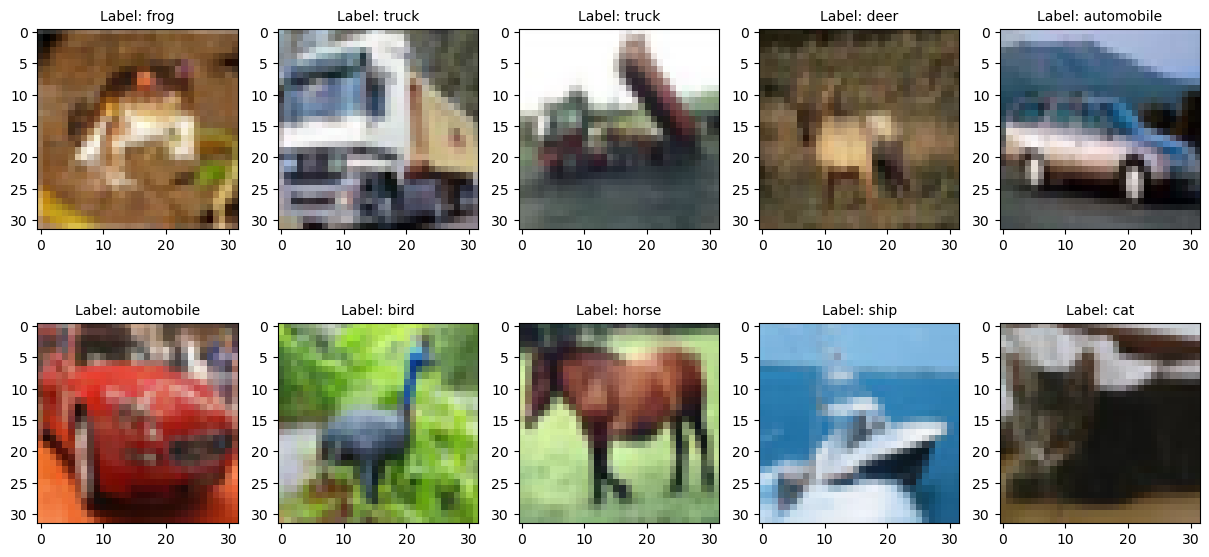

In [7]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  ax[i].imshow(image)
  ax[i].set_title(f"Label: {class_name[label.argmax()]}",  fontsize=10)

### Creating the model
We are training a ResNet-18 model, which is easy to implement and an excellent choice for datasets like CIFAR-10 and MNIST due to its simplicity and manageable number of parameters. 

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                  

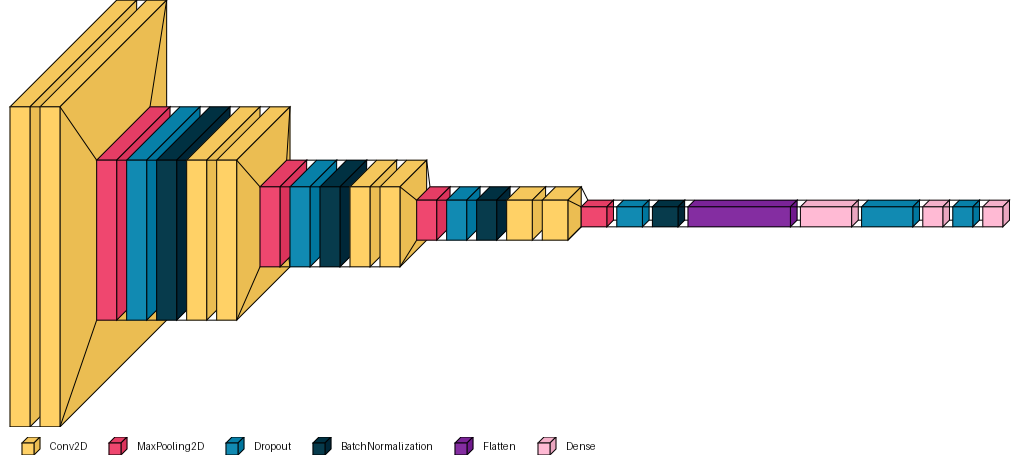

In [9]:
import visualkeras
visualkeras.layered_view(model, scale_xy=10, legend=True)

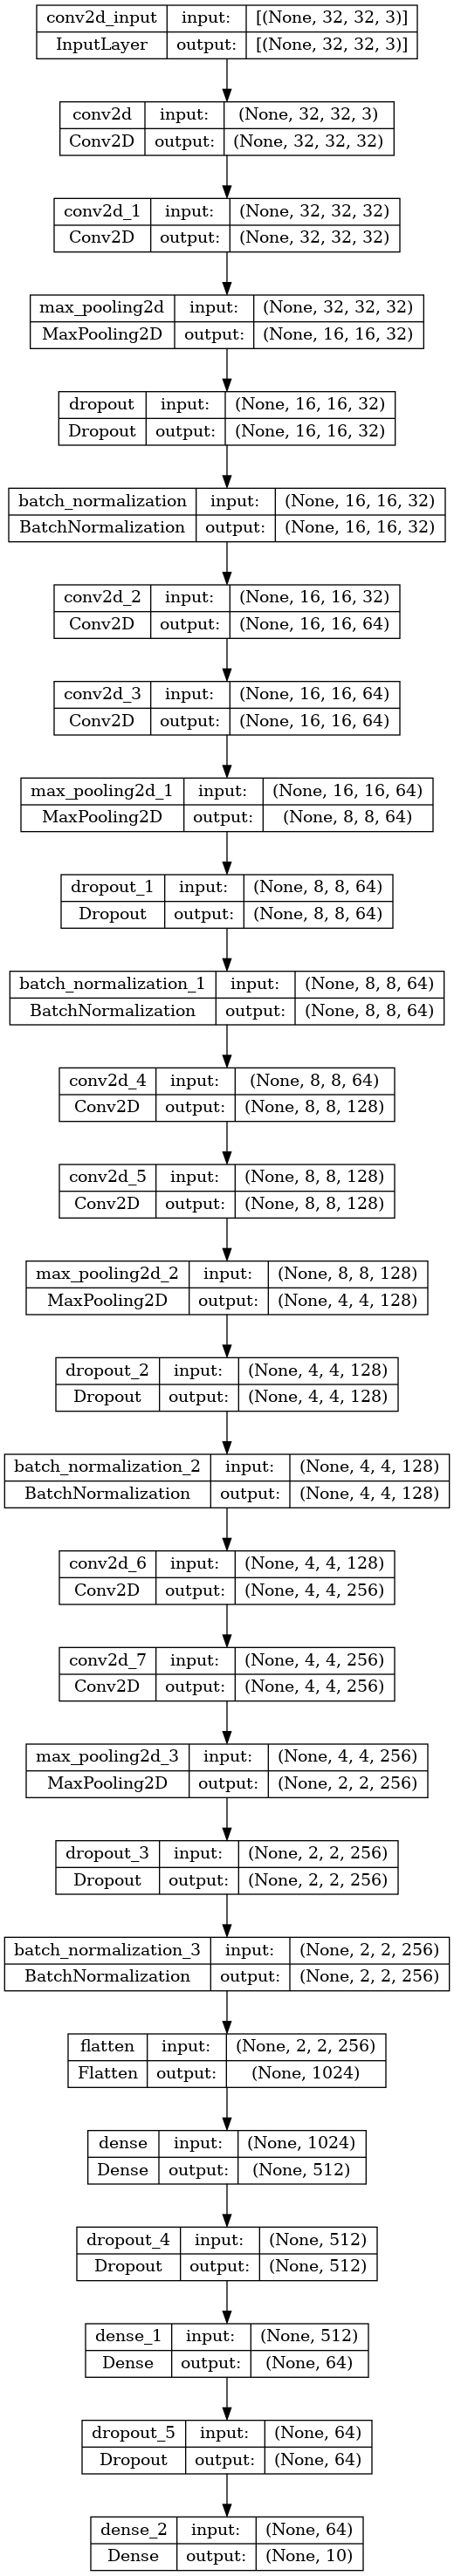

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Train the model.

In [ ]:
# history = model.fit(x_train, y_train, epochs=250)
# Save/Load the model 
# model.save('./../Models/cifar10_cnn.keras')
model = tf.keras.models.load_model('./../Models/cifar10_cnn.keras')

2025-01-16 11:16:39.137721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32548 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2025-01-16 11:16:39.364387: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2025-01-16 11:16:40.210233: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_7/bias/Assign' id:1066 op device:{requested: '', assigned: ''} def:{{{node dense_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_7/bias, dense_7/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-16 11:16:41.313972: W tensorflow/c/c_api.cc:291] Operation '{name:'batc

### Evaluate model accuracy on test data.

In [12]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2025-01-16 11:17:13.499876: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:1374 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_8_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-16 11:17:13.748957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_12/cond/then/_202/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-16 11:17:13.936299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902


Accuracy on test data: 85.26%


### Create a Keras Classifier from ART

In [13]:
# after normalizing the data
min = 0
max = 1

classifier = KerasClassifier(model=model, clip_values=(min, max))

### **Carlini and Wagner L_0 Attack**

> class art.attacks.evasion.CarliniL0Method(classifier: CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, binary_search_steps: int = 10, max_iter: int = 10, initial_const: float = 0.01, mask: Optional[ndarray] = None, warm_start: bool = True, max_halving: int = 5, max_doubling: int = 5, batch_size: int = 1, verbose: bool = True)


The L_0 distance metric is non-differentiable and therefore is ill-suited for standard gradient descent. Instead, we use an iterative algorithm that, in each iteration, identifies some features that don’t have much effect on the classifier output and then fixes those features, so their value will never be changed. The set of fixed features grows in each iteration until we have, by process of elimination, identified a minimal (but possibly not minimum) subset of features that can be modified to generate an adversarial example. In each iteration, we use our L_2 attack to identify which features are unimportant [Carlini and Wagner, 2016].*
Paper link: https://arxiv.org/abs/1608.04644


*\_\_init__(classifier: CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, binary_search_steps: int = 10, max_iter: int = 10, initial_const: float = 0.01, mask: Optional[ndarray] = None, warm_start: bool = True, max_halving: int = 5, max_doubling: int = 5, batch_size: int = 1, verbose: bool = True)*

**Create a Carlini&Wagner L_0 attack instance.**

    Parameters
* classifier – A trained classifier.
* confidence (float) – Confidence of adversarial examples: a higher value produces examples that are farther away, from the original input, but classified with higher confidence as the target class.
* targeted (bool) – Should the attack target one specific class.
* learning_rate (float) – The initial learning rate for the attack algorithm. Smaller values produce better results but are slower to converge.
* binary_search_steps (int) – Number of times to adjust constant with binary search (positive value). If binary_search_steps is large, then the algorithm is not very sensitive to the value of initial_const. Note that the values gamma=0.999999 and c_upper=10e10 are hardcoded with the same values used by the authors of the method.
* max_iter (int) – The maximum number of iterations.
* initial_const (float) – The initial trade-off constant c to use to tune the relative importance of distance and confidence. If binary_search_steps is large, the initial constant is not important, as discussed in Carlini and Wagner (2016).
* mask – The initial features that can be modified by the algorithm. If not specified, the algorithm uses the full feature set.
* warm_start (bool) – Instead of starting gradient descent in each iteration from the initial image. we start the gradient descent from the solution found on the previous iteration.
* max_halving (int) – Maximum number of halving steps in the line search optimization.
* max_doubling (int) – Maximum number of doubling steps in the line search optimization.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* verbose (bool) – Show progress bars.

**generate(x: ndarray, y: Optional[ndarray] = None, \*\*kwargs) → ndarray**

Generate adversarial samples and return them in an array.

    Return type
* ndarray
    
    
    Parameters
* x (ndarray) – An array with the original inputs to be attacked.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). If self.targeted is true, then y represents the target labels. If self.targeted is true, then y_val represents the target labels. Otherwise, the targets are the original class labels.


    Returns
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#carlini-and-wagner-l-0-attack

### Create an ART Carlini and Wagner L_0 Attack.

In [14]:
attack_cw_l0 = CarliniL0Method(classifier=classifier,
                              max_iter=10,
                              learning_rate=0.01,
                              initial_const=1e0,
                               verbose = True
                               )

### Generate adversarial test data.

In [56]:
x_test_adv = attack_cw_l0.generate(x_test)
np.save('attack_cw_l0_generated_data.npy', x_test_adv)

2025-01-16 11:17:35.673362: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_8/Softmax' id:1105 op device:{requested: '', assigned: ''} def:{{{node dense_8/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_8/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-16 11:17:35.882113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_12/cond/then/_202/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-16 11:18:57.323181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_12/cond/then/_202/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOpt

### Visualise the first adversarial test sample.

In [18]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=12)

### Evaluate accuracy on adversarial test data and calculate average perturbation.

In [46]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 75.40%
Average perturbation: 0.01


###  Carlini and Wagner L_2 Attack

> class art.attacks.evasion.CarliniL2Method(classifier: CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, binary_search_steps: int = 10, max_iter: int = 10, initial_const: float = 0.01, max_halving: int = 5, max_doubling: int = 5, batch_size: int = 1, verbose: bool = True)

The L_2 optimized attack of Carlini and Wagner (2016). This attack is among the most effective and should be used among the primary attacks to evaluate potential defences. A major difference wrt to the original implementation (https://github.com/carlini/nn_robust_attacks) is that we use line search in the optimization of the attack objective.
* Paper link: https://arxiv.org/abs/1608.04644

*\_\_init__(classifier: CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, binary_search_steps: int = 10, max_iter: int = 10, initial_const: float = 0.01, max_halving: int = 5, max_doubling: int = 5, batch_size: int = 1, verbose: bool = True) → None*

**Create a Carlini&Wagner L_2 attack instance.**

    Parameters:
* classifier – A trained classifier.
* confidence (float) – Confidence of adversarial examples: a higher value produces examples that are farther away, from the original input, but classified with higher confidence as the target class.
* targeted (bool) – Should the attack target one specific class.
* learning_rate (float) – The initial learning rate for the attack algorithm. Smaller values produce better results but are slower to converge.
* binary_search_steps (int) – Number of times to adjust constant with binary search (positive value). If binary_search_steps is large, then the algorithm is not very sensitive to the value of initial_const. Note that the values gamma=0.999999 and c_upper=10e10 are hardcoded with the same values used by the authors of the method.
* max_iter (int) – The maximum number of iterations.
* initial_const (float) – The initial trade-off constant c to use to tune the relative importance of distance and confidence. If binary_search_steps is large, the initial constant is not important, as discussed in Carlini and Wagner (2016).
* max_halving (int) – Maximum number of halving steps in the line search optimization.
* max_doubling (int) – Maximum number of doubling steps in the line search optimization.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* verbose (bool) – Show progress bars.

    
**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**

Generate adversarial samples and return them in an array.

    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs to be attacked.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). If self.targeted is true, then y represents the target labels. If self.targeted is true, then y_val represents the target labels. Otherwise, the targets are the original class labels.

    
    Returns:
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#carlini-and-wagner-l-2-attack



### Create a ART Carlini&Wagner Infinity-norm attack.

In [47]:
attack_cw_l2 = CarliniL2Method(classifier=classifier,
                              max_iter=100,
                              learning_rate=0.01,
                              initial_const=1e0,
                              )

### Generate adversarial test data.

In [54]:
x_test_adv = attack_cw_l2.generate(x_test)

C&W L_2:   0%|          | 0/500 [00:00<?, ?it/s]

In [55]:
# x_test_adv = attack_cw_l0.generate(x_test)
np.save('attack_cw_l2_generated_data.npy', x_test_adv)

### Visualise the first adversarial test sample.

In [19]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=12)

### Evaluate accuracy on adversarial test data and calculate average perturbation.

In [50]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 75.60%
Average perturbation: 0.01


### Carlini&Wagner Infinity-norm attack

> class art.attacks.evasion.CarliniLInfMethod(classifier: CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, max_iter: int = 10, decrease_factor: float = 0.9, initial_const: float = 1e-05, largest_const: float = 20.0, const_factor: float = 2.0, batch_size: int = 1, verbose: bool = True)

This is a modified version of the L_2 optimized attack of Carlini and Wagner (2016). It controls the L_Inf norm, i.e. the maximum perturbation applied to each pixel.

*\_\_init__(classifier: CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, max_iter: int = 10, decrease_factor: float = 0.9, initial_const: float = 1e-05, largest_const: float = 20.0, const_factor: float = 2.0, batch_size: int = 1, verbose: bool = True) → None*

**Create a Carlini&Wagner L_Inf attack instance.**

    Parameters:
* classifier – A trained classifier.
* confidence (float) – Confidence of adversarial examples: a higher value produces examples that are farther away, from the original input, but classified with higher confidence as the target class.
* targeted (bool) – Should the attack target one specific class.
* learning_rate (float) – The initial learning rate for the attack algorithm. Smaller values produce better results but are slower to converge.
* max_iter (int) – The maximum number of iterations.
* decrease_factor (float) – The rate of shrinking tau, values in 0 < decrease_factor < 1 where larger is more accurate.
* initial_const (float) – The initial value of constant c.
* largest_const (float) – The largest value of constant c.
* const_factor (float) – The rate of increasing constant c with const_factor > 1, where smaller more accurate.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* verbose (bool) – Show progress bars.

**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**

Generate adversarial samples and return them in an array.

    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs to be attacked.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). If self.targeted is true, then y_val represents the target labels. Otherwise, the targets are the original class labels.

    
    Returns:
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#carlini-and-wagner-l-inf-attack



### Create a ART Carlini&Wagner Infinity-norm attack.

In [51]:
attack_cw_inf = CarliniLInfMethod(classifier=classifier,
                              max_iter=100,
                              learning_rate=0.01,
                              initial_const=1e0,
                              largest_const=2e0)

### Generate adversarial test data.

In [52]:
x_test_adv = attack_cw_inf.generate(x_test)

C&W L_inf:   0%|          | 0/500 [00:00<?, ?it/s]

In [53]:
np.save('attack_cw_inf_generated_data.npy', x_test_adv)

### Visualise the first adversarial test sample.

In [20]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=12)

### Evaluate accuracy on adversarial test data and calculate average perturbation.

In [ ]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 27.00%
Average perturbation: 0.02


## Summary of Carlini and Wagner Attack Implementation on a Dataset
#### **Overview**

I have implemented the Carlini and Wagner (C&W) attack on a dataset comprising images from multiple classes. The C&W attack is a sophisticated adversarial attack method designed to evaluate and challenge the robustness of machine learning models, particularly deep neural networks. This summary explains the workings of the C&W attack, its implementation, and the impact of various parameters on the effectiveness of the attack.

#### **C&W Attack Mechanism**

The Carlini and Wagner attack is an optimization-based adversarial attack that aims to find minimal perturbations necessary to mislead the model while ensuring the perturbed images remain visually similar to the original ones. The attack minimizes the perturbation subject to the constraint that the perturbed image is misclassified by the model. The key steps in the C&W attack are:

1. Objective Function: Define an objective function that combines the goal of minimizing the perturbation with the goal of misclassifying the input. The C&W attack typically uses the following objective function:
    min⁡∥δ∥p+c⋅f(x+δ)
    min∥δ∥p​+c⋅f(x+δ)

2. where δδ is the perturbation, ∥δ∥p∥δ∥p​ is the p-norm of the perturbation, cc is a constant balancing the two objectives, and ff is a function that measures the success of the attack (i.e., whether the perturbed image x+δx+δ is misclassified).

3. Optimization: Use a gradient-based optimization method to solve the above objective function. The optimization aims to find the smallest perturbation δδ that misleads the model.

4. Perturbation Bound: Ensure the perturbation δδ remains within a specified range to maintain the visual similarity between the original and perturbed images.

#### **Impact of Parameters**

The success and subtlety of the C&W attack are influenced by several parameters:

* Norm (p-norm): The choice of norm (typically L2L2​ or L∞L∞​) affects the nature of the perturbation. The L2L2​ norm aims for minimal overall change, while the L∞L∞​ norm limits the maximum change to any single pixel.
* Constant cc: This parameter balances the trade-off between minimizing the perturbation and ensuring successful misclassification. A larger cc emphasizes misclassification, potentially leading to larger perturbations.
* Optimization Parameters: Learning rate, number of iterations, and other optimization settings can impact the efficiency and effectiveness of the attack.

#### **Results and Observations**

The implementation of the C&W attack on the dataset demonstrated the following:

* Small Perturbations: The C&W attack is effective in generating adversarial examples with minimal perceptual changes. Even small perturbations can significantly decrease the model's accuracy.
* Parameter Sensitivity: The success of the attack is highly sensitive to the choice of parameters. Fine-tuning cc and the norm used is crucial for balancing attack success and perturbation visibility.
* Model Robustness: The attack reveals vulnerabilities in the model, highlighting the need for improved robustness and adversarial training.

#### **Conclusion**

The Carlini and Wagner attack showcases the vulnerability of machine learning models to carefully crafted adversarial examples. By optimizing perturbations to be minimal yet effective, the C&W attack challenges the robustness of neural networks. Understanding and mitigating such attacks are essential for developing resilient models. Experimenting with different parameters provides insights into the trade-offs between attack success and perturbation subtlety, guiding the development of more secure machine learning systems.